# Solving the Schroedinger Equations Using the Finite Difference Itme Domain Method

10.1088/1751-8113/40/8/013

In [1]:
import dataclasses
import itertools
import math

import numpy as np
from scipy.sparse import diags

from IPython import display
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
@dataclasses.dataclass(frozen=True)
class Boundary:
    start: float
    end: float
    step: float

In [3]:
def cartesian(arrays):
    shape = [a.size for a in arrays]
    shape.append(-1)
    def inner(arrays, out=None):
        arrays = [np.asarray(a) for a in arrays]
        dtype = arrays[0].dtype

        asx = [a.size for a in arrays]
        n = np.prod(asx)

        if out is None:
            out = np.zeros([n, len(arrays)], dtype=dtype)

        m = n // arrays[0].size
        out[:, 0] = np.repeat(arrays[0], m)
        if arrays[1:]:
            inner(arrays[1:], out[0:m, 1:])
            for j in range(1, arrays[0].size):
                out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
        return out
    out = inner(arrays, out=None)
    out =  out.reshape(shape)
    return out

In [18]:
class DirichletSystem:
    def __init__(self, pot, time_dom, spatial_doms, bd_cond=None, **kwargs) -> None:
        self.pot = pot
        # 0: time, 1: X, 2: Y, 3: Z
        self.time_dom = time_dom
        self.spat_dom = list(spatial_doms)
        self.vol = np.prod([dom.step for dom in self.spat_dom])
        self.time_len = int((time_dom.end - time_dom.start) / time_dom.step) + 1
        self._init_mesh()
        # self._initialize()
        self.bd_cond = bd_cond
    
    def _init_mesh(self):
        self.spaces = [np.linspace(dom.start, dom.end, int((dom.end - dom.start) / dom.step) + 1) for dom in self.spat_dom]
        space_meshs = [x for x in np.meshgrid(*self.spaces, indexing='ij')]
        print(space_meshs[0].shape)
        self.sol_mesh = np.zeros([self.time_len, *space_meshs[0].shape])
        self.sol_shape = tuple(space_meshs[0].shape)
        self.space_meshs = np.asarray([x.flatten() for x in space_meshs])
        self.ndim = len(self.sol_shape)

    def normalize(self, psi):
        nn = np.sqrt(np.sum(psi * psi) * self.vol) + 0.001
        nn = 1.0 / nn
        out = psi * nn
        return out

    def _initialize(self, psi0_grid):
        self.sol_mesh[0] = self.normalize(psi0_grid)
        self._apply_boundary(0)

        pot_grid = np.zeros(np.prod(self.sol_shape))
        for i, xi in enumerate(zip(*self.space_meshs)):
            pot_grid[i] = self.pot(*xi)
        self.pot_grid = pot_grid.reshape(self.sol_shape)

    def set_psi0_by_func(self, func):
        psi0_grid = np.zeros(np.prod(self.sol_shape))
        for i, xi in enumerate(zip(*self.space_meshs)):
            psi0_grid[i] = func(*xi)
        psi0_grid = psi0_grid.reshape(self.sol_shape)
        self._initialize(psi0_grid)

    def set_psi0_by_grid(self, psi0_grid):
        self._initialize(psi0_grid)

    def _apply_boundary(self, n):
        if self.bd_cond is None:
            sx = slice(None, None, None)
            for i, l in enumerate(self.sol_shape):
                ind = tuple([0 if i == j else sx for j in range(self.ndim)])
                self.sol_mesh[n][ind] = 0.0
                ind = tuple([l - 1 if i == j else sx for j in range(self.ndim)])
                self.sol_mesh[n][ind] = 0.0
                
    def solve(self):
        dt = self.time_dom.step
        self.energy_series = np.zeros(self.time_len)
        sx = slice(None, None, None)

        beta = (1.0 + 0.5 * dt * self.pot_grid)
        alpha = (1.0 - 0.5 * dt * self.pot_grid) / beta

        for n in range(0, self.time_len):
            kine = np.zeros(self.sol_shape)
            px = self.sol_mesh[n]

            for i in range(self.ndim):
                ind1 = tuple([slice(1, -1, None) if i == j else sx for j in range(self.ndim)])
                ind2 = tuple([slice(0, -2, None) if i == j else sx for j in range(self.ndim)])
                ind3 = tuple([slice(2, None, None) if i == j else sx for j in range(self.ndim)])

                
                term = px[ind2] + px[ind3] - 2.0 * px[ind1]
                term /= (2.0 * self.spat_dom[i].step ** 2)

                kine[ind1] += term

            energy_before = np.sum(self.pot_grid * px * px) - (kine * px).sum()
            energy_before /= (px * px).sum()

            self.energy_series[n] = energy_before # * self.vol ** 2
            
            if n + 1 < self.time_len:
                self.sol_mesh[n + 1] = alpha * self.sol_mesh[n]
                self.sol_mesh[n + 1] += dt * beta * kine
                self._apply_boundary(n + 1)
                self.sol_mesh[n + 1] = self.normalize(self.sol_mesh[n + 1])

    def get_solution(self):
        return self.spaces, self.sol_mesh

    def get_energy(self):
        return self.energy_series

In [33]:
t0, t1, dt = 0.0, 1.0, 1.0e-05
x0, x1, dx = 0.0, 1.0, 0.01

dom_t = Boundary(t0, t1, dt)
dom_x = Boundary(x0, x1, dx)

def pot(mesh):
    return np.zeros_like(mesh)

def init(x):
    # return 0.25 - (x - 0.5) ** 2
    return np.random.randn(*x.shape)

system_1 = DirichletSystem(pot=pot, time_dom=dom_t, spatial_doms=[dom_x])
system_1.set_psi0_by_func(init)
system_1.solve()

(101,)


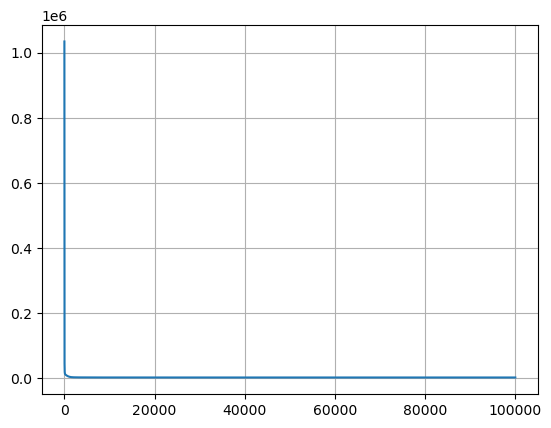

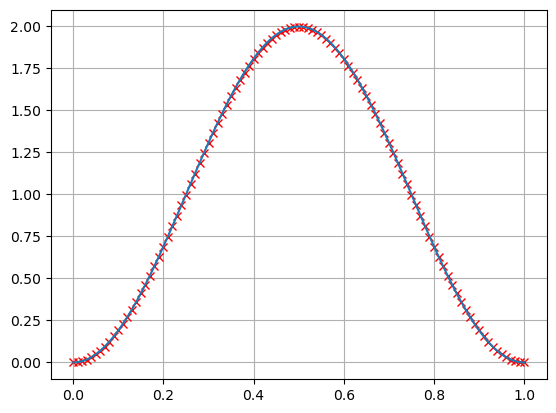

In [34]:
X, U = system_1.get_solution()
energies = system_1.get_energy()

fig1, ax1 = plt.subplots()
ax1.plot(energies)
ax1.grid()
plt.show(fig1)

fig2, ax2 = plt.subplots()
ax2.plot(X[0], U[-1] ** 2, 'rx')
ax2.plot(X[0], 2.0 * np.sin(X[0] * np.pi) **2)
ax2.grid()
plt.show(fig2)

In [7]:
energies[-1]

4.934396342684688

In [8]:
np.pi**2 / 2

4.934802200544679

In [9]:
t0, t1, dt = 0.0, 1.0, 1.0e-05
x0, x1, dx = -10.0, 10.0, 0.1

dom_t = Boundary(t0, t1, dt)
dom_x = Boundary(x0, x1, dx)

def pot(mesh):
    return 0.5 * np.sum(mesh * mesh)

def init(x):
    return 100.0 - x ** 2
    # return np.random.randn(*x.shape)

system_1 = DirichletSystem(pot=pot, time_dom=dom_t, spatial_doms=[dom_x])
system_1.set_psi0_by_func(init)
system_1.solve()

(201,)


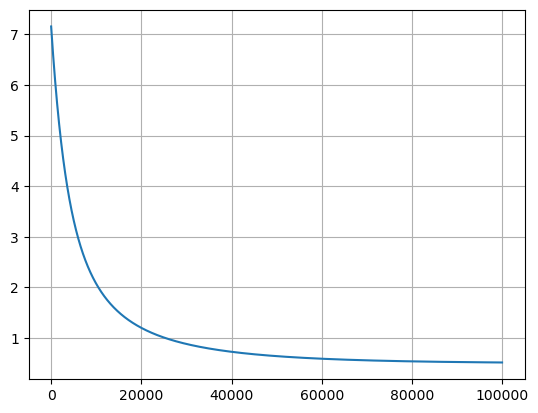

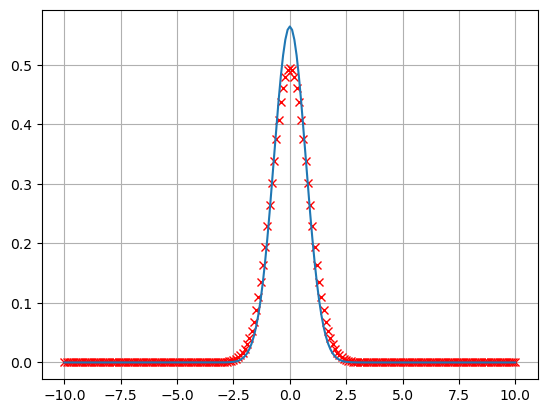

0.5169143737561377


In [10]:
X, U = system_1.get_solution()
energies = system_1.get_energy()

fig1, ax1 = plt.subplots()
ax1.plot(energies)
ax1.grid()
plt.show(fig1)

fig2, ax2 = plt.subplots()
X = X[0]
ax2.plot(X, U[-1] ** 2, 'rx')
ax2.plot(X, np.exp(-1.0 * X * X) / np.sqrt(np.pi))
ax2.grid()
plt.show(fig2)

print(energies[-1])

In [35]:
t0, t1, dt = 0.0, 1.0, 1.0e-05
x0, x1, dx = 0.0, 1.0, 0.02
y0, y1, dy = 0.0, 1.0, 0.02

dom_t = Boundary(t0, t1, dt)
dom_x = Boundary(x0, x1, dx)
dom_y = Boundary(y0, y1, dy)

def pot(x, y):
    return 0.0

def init(x, y):
    return -1.0 *  ((x - 0.5) ** 2 + (y - 0.5) ** 2) + 0.5
    # return np.random.randn(*x.shape)

system_1 = DirichletSystem(pot=pot, time_dom=dom_t, spatial_doms=[dom_x, dom_y])
system_1.set_psi0_by_func(init)
system_1.solve()

(51, 51)


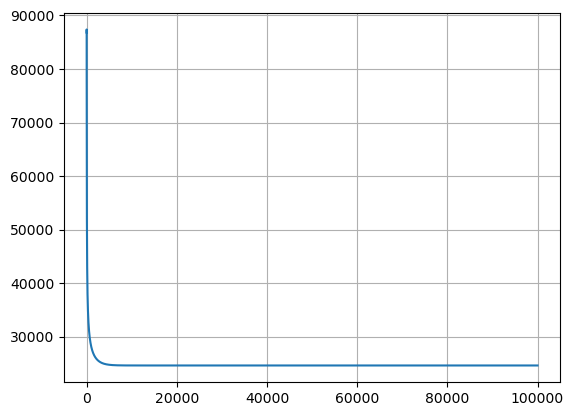

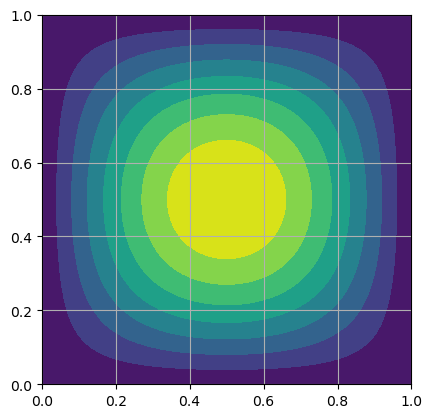

24616.582660343636


In [36]:
X, U = system_1.get_solution()
energies = system_1.get_energy()

fig1, ax1 = plt.subplots()
ax1.plot(energies)
ax1.grid()
plt.show(fig1)

zs = U[-1]
fig2, ax2 = plt.subplots()
xs, ys = np.meshgrid(*X, indexing='ij')
ax2.contourf(xs, ys, zs)
# ax2.plot(X[0], U[-1][:, 50])
ax2.grid()
ax2.set_aspect('equal')
plt.show(fig2)

print(energies[-1])